Net(
  (fc1): Linear(in_features=32, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)


 10%|████▍                                       | 1/10 [00:03<00:30,  3.41s/it]

Epoch 000: | Loss: 0.58224 | AUC: 0.500


 20%|████████▊                                   | 2/10 [00:06<00:26,  3.33s/it]

Epoch 001: | Loss: 0.57840 | AUC: 0.500


 30%|█████████████▏                              | 3/10 [00:09<00:23,  3.30s/it]

Epoch 002: | Loss: 0.57815 | AUC: 0.503


 40%|█████████████████▌                          | 4/10 [00:13<00:19,  3.33s/it]

Epoch 003: | Loss: 0.57812 | AUC: 0.503


 50%|██████████████████████                      | 5/10 [00:16<00:16,  3.30s/it]

Epoch 004: | Loss: 0.57812 | AUC: 0.501


 60%|██████████████████████████▍                 | 6/10 [00:19<00:13,  3.30s/it]

Epoch 005: | Loss: 0.57811 | AUC: 0.503


 70%|██████████████████████████████▊             | 7/10 [00:23<00:09,  3.30s/it]

Epoch 006: | Loss: 0.57811 | AUC: 0.499


 80%|███████████████████████████████████▏        | 8/10 [00:26<00:06,  3.28s/it]

Epoch 007: | Loss: 0.57812 | AUC: 0.502


 90%|███████████████████████████████████████▌    | 9/10 [00:29<00:03,  3.31s/it]

Epoch 008: | Loss: 0.57811 | AUC: 0.500


100%|███████████████████████████████████████████| 10/10 [00:33<00:00,  3.31s/it]

Epoch 009: | Loss: 0.57811 | AUC: 0.500


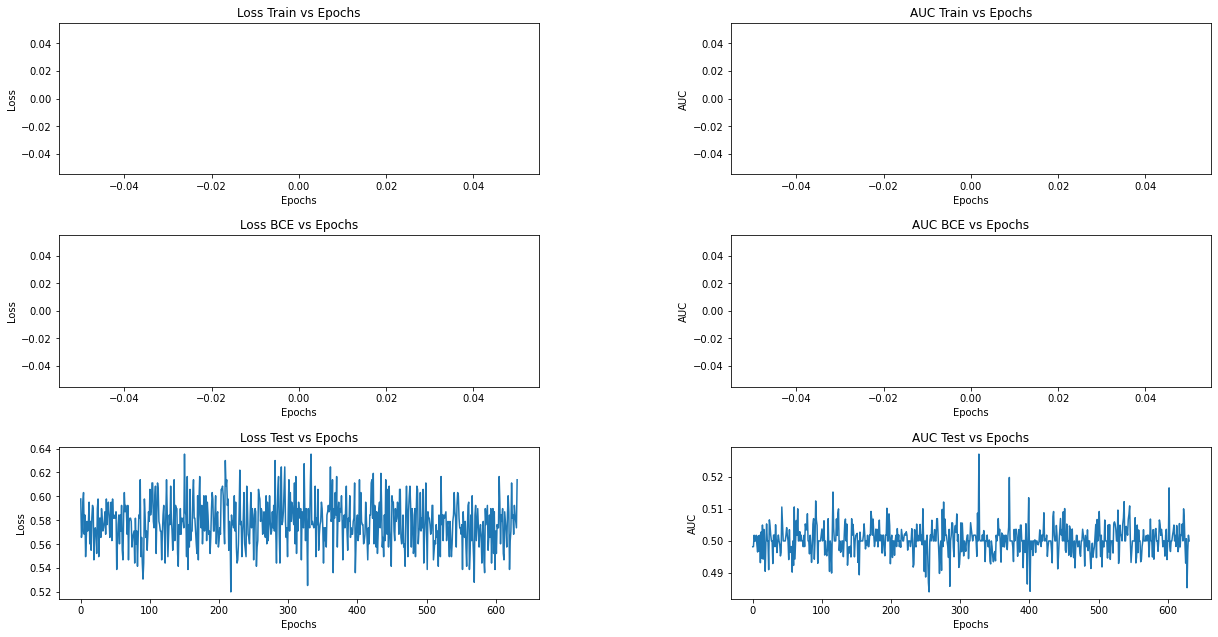

<Figure size 1600x800 with 0 Axes>

In [5]:
from fastai.tabular.all import *
from fastcore.utils import *
import pandas
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset
import torch
import torch.nn
import torch.nn.functional as F
import torch.optim as opt

from utils import *
from nn_architecture import Net
#from utils import *

emb_valid_xs = pd.read_csv("../dataset/emb_valid_xs.csv")
df = pd.read_csv("../dataset/df.csv")
emb_xs = pd.read_csv("../dataset/emb_xs.csv")

train_loader, valid_loader = pandas_to_tensor(df, emb_xs, emb_valid_xs)


nb_clust=1

# -1 cause we remove the target
net = Net(32, nb_clust)
print(net)

max_epochs = 10
#loss_fct = nn.CrossEntropyLoss()
loss_fct = nn.BCEWithLogitsLoss()
l_loss = list()
l_loss_test = list()
l_roc_train = list()
l_roc_test = list()

optim = opt.Adam(net.parameters(), lr=0.01)


for epoch in tqdm(range(max_epochs)):
    t0 = datetime.now()
    net.train()
    epoch_loss = 0
    epoch_auc = 0
    for batch, (x, y) in enumerate(train_loader):
        
        optim.zero_grad()
        
        # Predict soft-targets and embeddings
        output = net(x, 1)
        
        loss = loss_fct(output, y)
        auc = roc_auc_score(y.detach().numpy(), torch.sigmoid(output).detach().numpy())
        loss.backward()
        
        optim.step()
        
        #l_loss.append(loss.item())
        #l_roc_train.append(roc_auc_score(y.detach().numpy(), torch.sigmoid(output).detach().numpy()))
        epoch_loss += loss.item()
        epoch_auc += auc
        
    print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | AUC: {epoch_auc/len(train_loader):.3f}')        
        


In [ ]:
with torch.no_grad():
    for batch, (x, y) in enumerate(valid_loader):
        output = net(x, 1)

        loss = loss_fct(output, y)
        l_loss_test.append(loss)
        
        l_roc_test.append(roc_auc_score(y.detach().numpy(), torch.sigmoid(output).detach().numpy()))
        
print_scores(l_loss, l_roc_train, l_loss, l_roc_train, l_roc_test, l_loss_test)